In [10]:
d_perovskite_values = range(100, 2000, 10)  # in nm

Processing data...


<Figure size 1200x800 with 0 Axes>

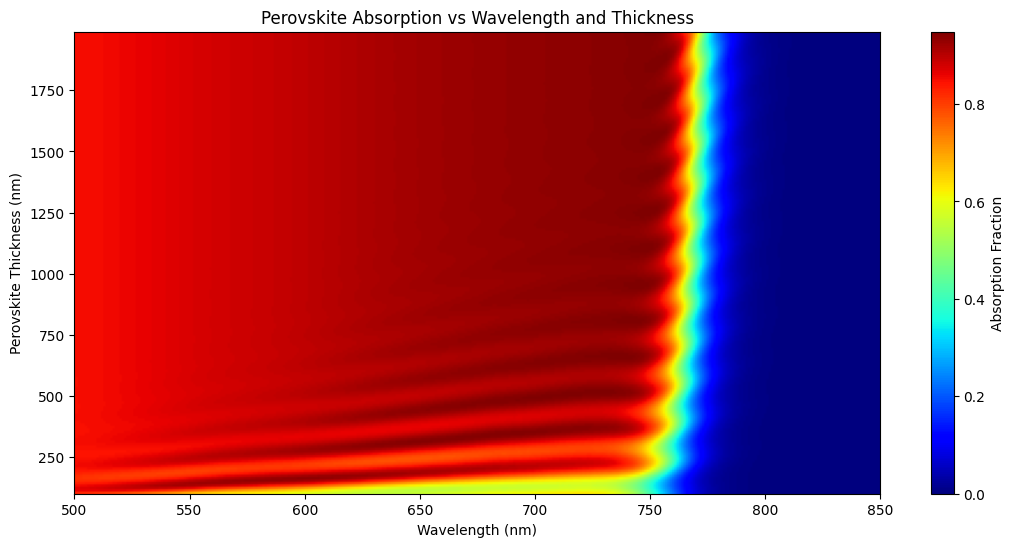

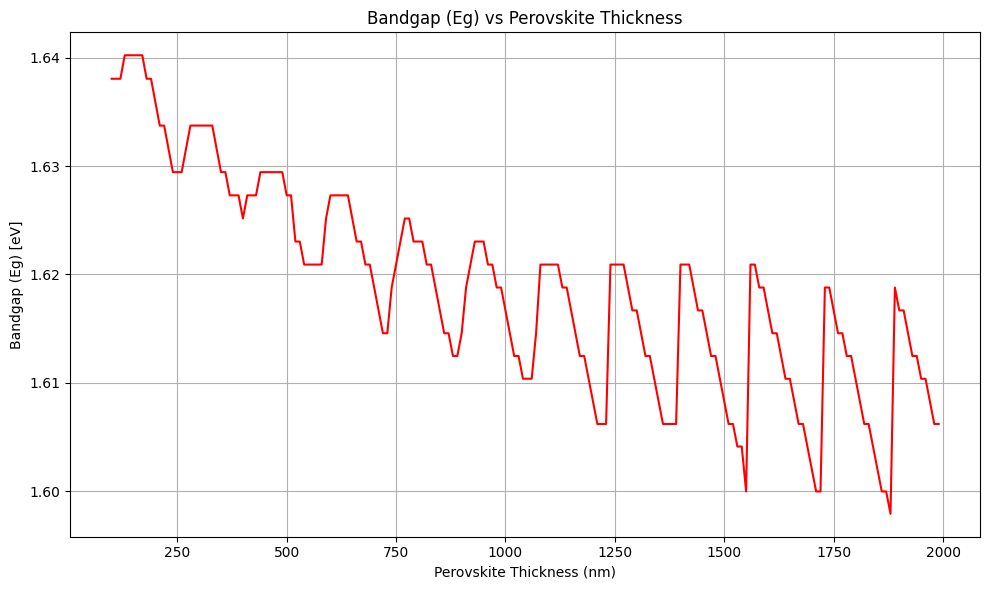

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tmm_core import inc_tmm, inc_absorp_in_each_layer

# Perovskite thickness values (you can change or add more values)

d_perovskite_values_all = list(d_perovskite_values)  # List of all thicknesses
d_perovskite_values_for_plot = d_perovskite_values_all[::5]  # Select every 5th thickness for plotting

# Layer thicknesses
d_glass = 1e4
d_ITO = 110
d_c60 = 20
d_Ag = 200

# Layer thicknesses
d_list = [np.inf, d_glass, d_ITO, None, d_c60, d_Ag, np.inf]  # Perovskite thickness to be set in the loop
n_names = ['air', 'glass', 'ITO', 'perovskite', 'C60', 'Ag', 'air']
c_list = ['i', 'i', 'c', 'c', 'c', 'c', 'i']  # Coherent or incoherent layers

# Load the nk files and compute complex refractive index
wvl_arrays = []
n_complex_arrays = []
wvl = []

for name in n_names:
    file_path = f'./nk/{name}.nk'  # Construct the file path
    try:
        # Read the data file, ignoring any extra columns
        df = pd.read_csv(file_path, sep='\t', usecols=[0, 1, 2], names=['wvl', 'n', 'k'], comment='#', header=None)
        
        # Convert to numeric, coercing errors to NaN
        df['n'] = pd.to_numeric(df['n'], errors='coerce')
        df['k'] = pd.to_numeric(df['k'], errors='coerce')
        df['wvl'] = pd.to_numeric(df['wvl'], errors='coerce')
        
        # Drop rows with NaN values
        df = df.dropna()
        
        # Slice rows 100:800 (inclusive of 100, exclusive of 801)
        df_trimmed = df.iloc[100:801]
        
        # Extract the wavelength and complex refractive index as simple NumPy arrays
        wvl_array = df_trimmed['wvl'].to_numpy()
        n_complex_array = (df_trimmed['n'] + 1j * df_trimmed['k']).to_numpy()
        
        # Append to the lists
        wvl_arrays.append(wvl_array)
        n_complex_arrays.append(n_complex_array)
        
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print(f"Processing data...")
# Convert the lists to arrays if needed
wvl_arrays = np.array(wvl_arrays, dtype=object)
n_complex_arrays = np.array(n_complex_arrays, dtype=object)
wvl = wvl_arrays[1]

# Initialize a list to store Eg values
Eg_values = []  # Store Eg for different Perovskite thicknesses
absorption_data = []  # To store absorption data for imshow

plt.figure(figsize=(12, 8))

# Loop through different thicknesses of the Perovskite layer and calculate Eg
for d_perovskite in d_perovskite_values_all:
    # Set the new Perovskite thickness in the d_list
    d_list[3] = d_perovskite  # Perovskite is the 4th layer (index 3)
    
    # Storage arrays
    R_vals = []  # Polarization-averaged reflection
    T_vals = []  # Polarization-averaged transmission
    absorption_layers = []  # Polarization-averaged absorption per layer

    # Loop over all wavelengths
    for i, lam_vac in enumerate(wvl):
        # Extract refractive indices for all layers at the current wavelength
        n_list_for_lambda = n_complex_arrays[:, i].astype(complex)

        # Perform incoherent transfer matrix calculation for s-polarization
        inc_data_s = inc_tmm('s', n_list_for_lambda, d_list, c_list, th_0=0, lam_vac=lam_vac)
        R_s = inc_data_s['R']
        T_s = inc_data_s['T']
        absorption_s = inc_absorp_in_each_layer(inc_data_s)

        # Perform incoherent transfer matrix calculation for p-polarization
        inc_data_p = inc_tmm('p', n_list_for_lambda, d_list, c_list, th_0=0, lam_vac=lam_vac)
        R_p = inc_data_p['R']
        T_p = inc_data_p['T']
        absorption_p = inc_absorp_in_each_layer(inc_data_p)

        # Average reflection and transmission
        R_avg = (R_s + R_p) / 2
        T_avg = (T_s + T_p) / 2
        R_vals.append(R_avg)
        T_vals.append(T_avg)

        # Average absorption in intermediate layers
        absorption_avg = [(a_s + a_p) / 2 for a_s, a_p in zip(absorption_s[1:-1], absorption_p[1:-1])]
        absorption_layers.append(absorption_avg)

    # Convert absorption to numpy array
    absorption_layers = np.array(absorption_layers)  # Shape: (701, num_intermediate_layers)

    # Calculate Eg for Perovskite layer
    for layer in range(absorption_layers.shape[1]):
        if n_names[layer + 1] == 'perovskite':
            # Calculate absorption for each wavelength-thickness pair
            absorption_layer_data = absorption_layers[:, layer]
            absorption_layer_data = np.nan_to_num(absorption_layer_data, nan=0.0, posinf=0.0, neginf=0.0)

            # Store the absorption data for imshow
            absorption_data.append(absorption_layer_data)

            # Calculate derivative of absorption to find Eg
            absorption_derivative = np.gradient(absorption_layer_data, wvl)

            # Find the index of the minimum derivative
            min_derivative_index = np.argmin(absorption_derivative)

            # Get the corresponding wavelength
            min_wavelength = wvl[min_derivative_index]

            # Calculate the bandgap Eg = 1240 / λ_min (in nm)
            Eg = 1240 / min_wavelength

            # Store the Eg value for this Perovskite thickness
            Eg_values.append((d_perovskite, Eg))

# Prepare the 2D plot of absorption data
absorption_data = np.array(absorption_data)  # Shape: (num_wavelengths, num_thicknesses)

# Plot the 2D absorption plot
plt.figure(figsize=(13,6))
cax = plt.imshow(absorption_data, aspect='auto', cmap='jet', extent=[min(wvl), max(wvl), min(d_perovskite_values_all), max(d_perovskite_values_all)], origin='lower')
plt.colorbar(cax, label='Absorption Fraction')
plt.xlabel('Wavelength (nm)')
plt.xlim([500, 850]) 
plt.ylabel('Perovskite Thickness (nm)')
plt.title('Perovskite Absorption vs Wavelength and Thickness')

# Plot Eg as a function of Perovskite thickness on top of the absorption plot
thicknesses = [thickness for thickness, Eg in Eg_values]
Eg_values_for_plot = [Eg for thickness, Eg in Eg_values]


# Add a second subplot for Eg vs thickness
plt.figure(figsize=(10,6))
plt.plot(thicknesses, Eg_values_for_plot, color='red')
plt.xlabel('Perovskite Thickness (nm)')
plt.ylabel('Bandgap (Eg) [eV]')
plt.title('Bandgap (Eg) vs Perovskite Thickness')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

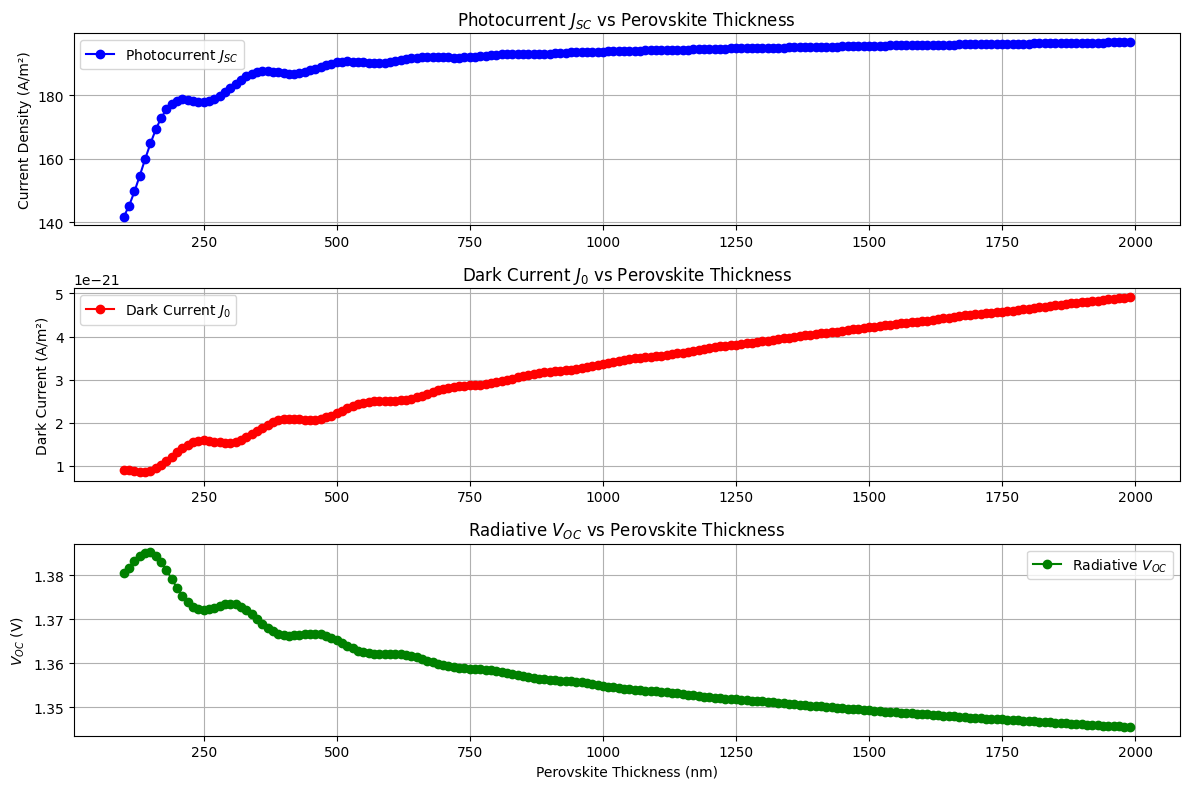

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import h, c, k, e

# Constants
T = 300  # Temperature in Kelvin
hc = h * c  # Planck constant times speed of light
q = e  # Electron charge
thermal_voltage = k * T / q  # kT/q in Volts

# Wavelength range (example, replace with your actual data)
wvl = wvl_arrays[1]
wvls = np.linspace(min(wvl), max(wvl), len(wvl))
wvl = wvls

# Load the AM1.5G spectrum
am15 = pd.read_csv("am15.csv", sep=',', header=None, names=['wavelength', 'global_tilted', 'direct_normal'])

# Convert 'wavelength' and 'direct_normal' to numeric (force conversion to float)
am15['wavelength'] = pd.to_numeric(am15['wavelength'], errors='coerce')
am15['direct_normal'] = pd.to_numeric(am15['direct_normal'], errors='coerce')

# Drop rows with NaN values
am15 = am15.dropna()

# Interpolate AM1.5G data to match wvl range
wavelengths = am15['wavelength'].to_numpy(dtype=float)
direct_flux = am15['direct_normal'].to_numpy(dtype=float)

am15_interp = np.interp(wvls, wavelengths, direct_flux)  # Interpolated direct flux

# Calculate photon flux from AM1.5G (photons/(nm·s·m²)) with correct units
# Power in W/(m²·nm) -> photons/(nm·s·m²)
photon_flux_am15 = am15_interp / (hc / (wvls * 1e-9))  # Convert W/(m²·nm) to photons/(nm·s·m²)

# Initialize lists to store results
Jsc_list = []  # Short-circuit current
J0_list = []  # Dark current
Voc_list = []  # Radiative open-circuit voltage

# Loop through thicknesses
for idx, d_perovskite in enumerate(d_perovskite_values_all):
    # Absorption for the current thickness
    absorption = absorption_data[idx]  # Absorption for this thickness

    # Jsc: Calculate short-circuit current (A/m²)
    absorbed_photon_flux = absorption * photon_flux_am15
    Jsc = np.trapezoid(absorbed_photon_flux, wvl) * q  # Convert to A/m²
    Jsc_list.append(Jsc)

    # Planck's Law to compute photon flux (photons/(m²·nm·s)) for black-body radiation at T = 300K
    bb_flux = (2 *np.pi * h * c**2 / (1e-9 * wvls)**5) / (np.exp(hc / (wvls * 1e-9 * k * T)) - 1)  # photons/(m²·nm·s)

    # J0: Dark current calculation (A/m²)
    # Absorption * black-body photon flux (bb_flux) gives absorbed photon flux
    absorbed_bb_flux = absorption * bb_flux

    # Integrate over wavelength to get total absorbed photon flux
    # Multiply by charge (q) to convert to current (in A/m²)
    J0 = np.trapezoid(absorbed_bb_flux, wvl*1e9) * q  # Convert to A/m²
    J0_list.append(J0)

    # Voc: Radiative open-circuit voltage (V)
    Voc = thermal_voltage * np.log(Jsc / J0)
    Voc_list.append(Voc)

# Convert results to arrays
Jsc_array = np.array(Jsc_list)
J0_array = np.array(J0_list)
Voc_array = np.array(Voc_list)

# Plot results
plt.figure(figsize=(12, 8))

# Plot Jsc vs thickness
plt.subplot(4, 1, 1)
plt.plot(d_perovskite_values_all, Jsc_array, 'b-o', label='Photocurrent $J_{SC}$')
plt.ylabel('Current Density (A/m²)')
plt.title('Photocurrent $J_{SC}$ vs Perovskite Thickness')
plt.legend()
plt.grid()

# Plot J0 vs thickness
plt.subplot(4, 1, 2)
plt.plot(d_perovskite_values_all, J0_array, 'r-o', label='Dark Current $J_0$')
plt.ylabel('Dark Current (A/m²)')
plt.title('Dark Current $J_0$ vs Perovskite Thickness')
plt.legend()
plt.grid()

# Plot Voc vs thickness
plt.subplot(4, 1, 3)
plt.plot(d_perovskite_values_all, Voc_array, 'g-o', label='Radiative $V_{OC}$')
plt.xlabel('Perovskite Thickness (nm)')
plt.ylabel('$V_{OC}$ (V)')
plt.title('Radiative $V_{OC}$ vs Perovskite Thickness')
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(d_perovskite_values_all, Eg_values_for_plot-Voc_array, 'g-o', label='loss $\delta V_{OC}$')
plt.xlabel('Perovskite Thickness (nm)')
plt.ylabel('$\delta V_{OC}$ (V)')
plt.legend()
plt.grid()




plt.tight_layout()
plt.show()